In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 

plt.style.use('seaborn-v0_8-whitegrid') 
sns.set_palette("pastel") 

try:
    plt.rcParams['font.family'] = 'NanumGothic'
    print("나눔고딕 폰트가 성공적으로 설정되었습니다.")
except Exception as e:
    print(f"나눔고딕 폰트 설정에 실패했습니다: {e}.")
    print("그래프의 한글이 깨질 수 있습니다. 나눔고딕 폰트 설치를 권장합니다.")
plt.rcParams['axes.unicode_minus'] = False 

VARIABLE_UNITS = {
    'cloud_cover': '(10분위)', 'dew_point': '(°C)', 'humidity': '(%)',
    'local_pressure': '(hPa)', 'min_cloud_height': '(100m)', 'precipitation': '(mm)',
    'sea_level_pressure': '(hPa)', 'snow_depth': '(cm)', 'sunshine_duration': '(hr)',
    'surface_temp': '(°C)', 'vapor_pressure': '(hPa)', 'visibility': '(10m)',
    'wind_speed': '(m/s)', 'wind_direction': '(°)',
    'climatology_temp': '(°C)', 'target': '(°C, 편차)'
}

def get_unit(column_name_or_base):
    """ 컬럼명 또는 기본 변수명으로 단위를 찾아 반환하는 헬퍼 함수.
        예: get_unit('surface_temp_12') 또는 get_unit('surface_temp') 또는 get_unit('target')
    """
    for base_key, unit_value in VARIABLE_UNITS.items():
       
        if base_key in column_name_or_base:
            return unit_value
    return "" 

PROCESSED_DATA_FILE_PATH = './input/processed/train_df_imputed.csv' 

try:
    train_df_analysis = pd.read_csv(PROCESSED_DATA_FILE_PATH)
    print(f"성공: '{PROCESSED_DATA_FILE_PATH}' 에서 전처리된 학습 데이터를 로드했습니다.")
    print(f"로드된 데이터 형태 (Shape): {train_df_analysis.shape}")

except FileNotFoundError:
    print(f"경고: '{PROCESSED_DATA_FILE_PATH}' 파일을 찾을 수 없습니다!")
    print("      이전 전처리 노트북 (`resolve_missing_values (3).ipynb` 등)에서")
    print("      처리된 데이터프레임(예: `train_df_imputed`)을 해당 경로에 파일로 저장했는지 확인해주세요.")
    print("      (예: `train_df_imputed.to_csv('./output/train_df_imputed.csv', index=False)`)")
    print("      파일 로드 실패로 인해 이후 EDA가 정상적으로 동작하지 않을 수 있습니다.")

if 'month' not in train_df_analysis.columns and 'date' in train_df_analysis.columns:
    try:
        train_df_analysis['month'] = pd.to_datetime(train_df_analysis['date'], format='%m-%d', errors='coerce').dt.month
        print("'month' 컬럼을 'date' 컬럼으로부터 생성했습니다.")
    except Exception as e:
        print(f"'date' 컬럼에서 'month' 추출 중 오류 발생: {e}. 'month' 컬럼이 필요한 분석에 문제가 있을 수 있습니다.")
        print("  'date' 컬럼의 형식을 확인하거나, 전처리 단계에서 'month'를 미리 생성해주세요.")

print("\n--- 상세 EDA (전처리 완료 데이터 사용) 준비 완료 ---")

나눔고딕 폰트가 성공적으로 설정되었습니다.
성공: './input/processed/train_df_imputed.csv' 에서 전처리된 학습 데이터를 로드했습니다.
로드된 데이터 형태 (Shape): (13132, 342)
'month' 컬럼을 'date' 컬럼으로부터 생성했습니다.

--- 상세 EDA (전처리 완료 데이터 사용) 준비 완료 ---


<Figure size 1000x50 with 0 Axes>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_5058/61085092.py:49: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=2.0)
/tmp/ipykernel_5058/61085092.py:49: UserWarning: Glyph 54200 (\N{HANGUL SYLLABLE PYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=2.0)
/tmp/ipykernel_5058/61085092.py:49: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=2.0)
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic

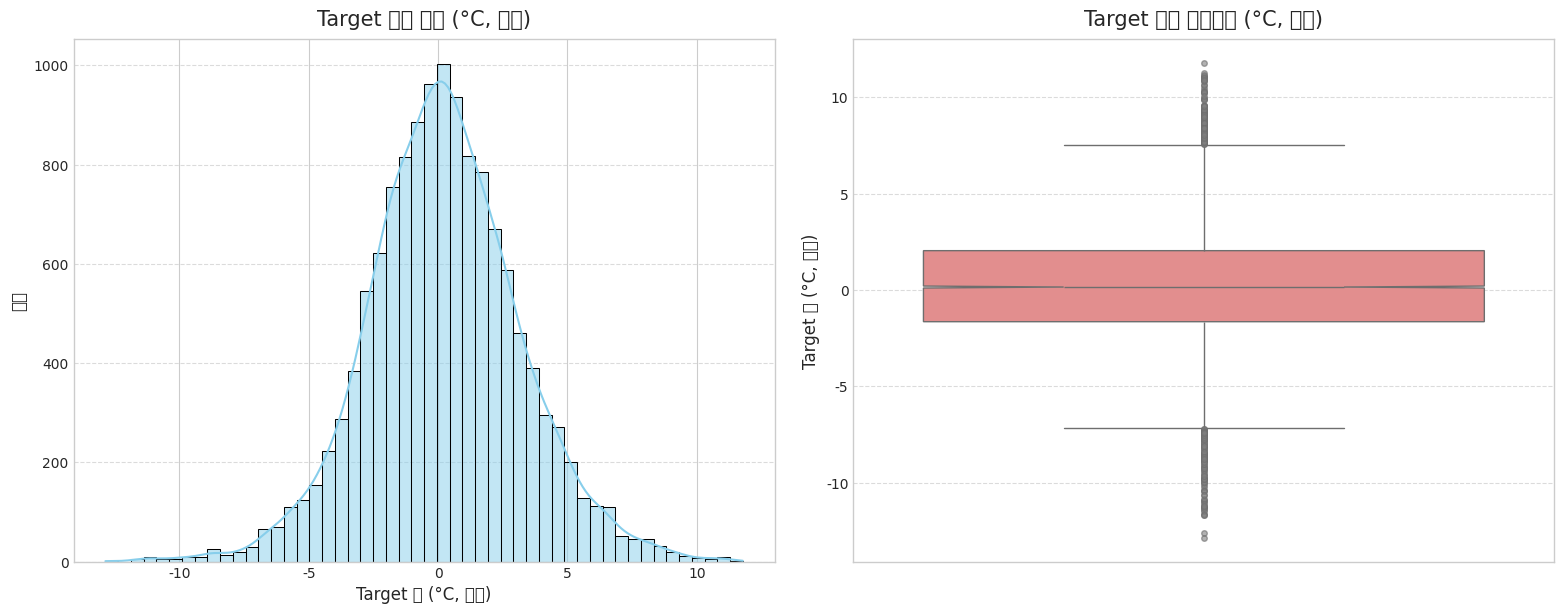


--- Target 변수의 기술 통계량 (NaN 값 제외) ---
  - 데이터 개수 (count): 13,132 개
  - 평균 (mean): 0.222 (°C, 편차)
  - 표준편차 (std): 2.961 (°C, 편차)
  - 최소값 (min): -12.864 (°C, 편차)
  - 제1사분위수 (25%): -1.643 (°C, 편차)
  - 중앙값 (median, 50%): 0.157 (°C, 편차)
  - 제3사분위수 (75%): 2.046 (°C, 편차)
  - 최대값 (max): 11.779 (°C, 편차)

--- Target 값의 편차 방향성 분석 (NaN 값 제외) ---
  - 과거 평균과 동일 (0인 경우): 0.02%
  - 과거 평균보다 더움 (양수인 경우): 52.45%
  - 과거 평균보다 추움 (음수인 경우): 47.53%


In [ ]:
if 'target' in train_df_analysis.columns:
    fig_title_target = plt.figure(figsize=(10, 0.5)) 
    plt.figtext(0.5, 0.5, '1. Target 변수 상세 분석 (전처리 후)',
                ha='center', va='center', fontsize=18, weight='bold', figure=fig_title_target)
    plt.show(fig_title_target)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6.5))
    target_unit = get_unit('target')
    target_data_for_plot = train_df_analysis['target'].dropna()

    if not target_data_for_plot.empty:
        sns.histplot(target_data_for_plot,
                     kde=True,
                     bins=50,
                     color='skyblue', 
                     ax=axes[0]
        )
        axes[0].set_title(f'Target 변수 분포 {target_unit}', fontsize=15, pad=10)
        axes[0].set_xlabel(f'Target 값 {target_unit}', fontsize=12)
        axes[0].set_ylabel('빈도', fontsize=12)
        axes[0].tick_params(axis='both', which='major', labelsize=10)
        axes[0].grid(axis='y', linestyle='--', alpha=0.7)
        sns.boxplot(y=target_data_for_plot, ax=axes[1], color='lightcoral', notch=True,
                    flierprops={'marker': 'o', 'markersize': 4, 'markerfacecolor': 'gray', 'alpha':0.6})
        axes[1].set_title(f'Target 변수 박스플롯 {target_unit}', fontsize=15, pad=10)
        axes[1].set_ylabel(f'Target 값 {target_unit}', fontsize=12)
        axes[1].tick_params(axis='y', which='major', labelsize=10)
        axes[1].tick_params(axis='x', which='major', bottom=False, labelbottom=False)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout(pad=2.0)
        plt.show()

        print("\n--- Target 변수의 기술 통계량 (NaN 값 제외) ---")
        target_stats = target_data_for_plot.describe()
        print(f"  - 데이터 개수 (count): {target_stats.get('count', 'N/A'):,.0f} 개")
        print(f"  - 평균 (mean): {target_stats.get('mean', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 표준편차 (std): {target_stats.get('std', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 최소값 (min): {target_stats.get('min', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 제1사분위수 (25%): {target_stats.get('25%', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 중앙값 (median, 50%): {target_stats.get('50%', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 제3사분위수 (75%): {target_stats.get('75%', 'N/A'):.3f} {target_unit.strip()}")
        print(f"  - 최대값 (max): {target_stats.get('max', 'N/A'):.3f} {target_unit.strip()}")

        print("\n--- Target 값의 편차 방향성 분석 (NaN 값 제외) ---")
        print(f"  - 과거 평균과 동일 (0인 경우): {(target_data_for_plot == 0).mean() * 100:.2f}%")
        print(f"  - 과거 평균보다 더움 (양수인 경우): {(target_data_for_plot > 0).mean() * 100:.2f}%")
        print(f"  - 과거 평균보다 추움 (음수인 경우): {(target_data_for_plot < 0).mean() * 100:.2f}%")
    else:
        print("경고: 'target' 데이터가 (NaN 제거 후) 비어있어 분석을 수행할 수 없습니다.")
else:
    print("경고: 'target' 컬럼이 train_df_analysis에 없습니다. Target 변수 분석을 건너<0xEB><0A><0x88>니다.")




<Figure size 1000x50 with 0 Axes>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_5058/3743780070.py:20: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.grid(axis='y', linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()
/tmp/ipykernel_5058/3743780070.py:20: UserWar

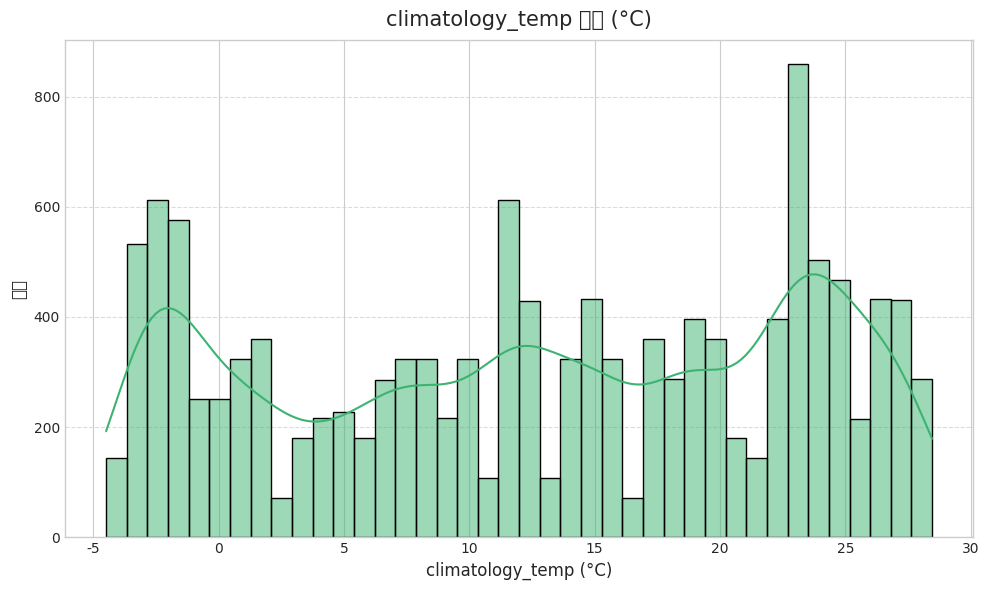


--- climatology_temp 변수의 기술 통계량 (NaN 값 제외) ---
  - 데이터 개수 (count): 13,132 개
  - 평균 (mean): 12.66 (°C)
  - 표준편차 (std): 10.02 (°C)
  - 최소값 (min): -4.49 (°C)
  - 제1사분위수 (25%): 3.29 (°C)
  - 중앙값 (median, 50%): 12.84 (°C)
  - 제3사분위수 (75%): 22.27 (°C)
  - 최대값 (max): 28.46 (°C)


In [ ]:
if 'climatology_temp' in train_df_analysis.columns:
    col_name_clima = 'climatology_temp'
    unit_clima = get_unit(col_name_clima)

    fig_title_clima = plt.figure(figsize=(10, 0.5))
    plt.figtext(0.5, 0.5, '2. climatology_temp (당일 과거 평균 기온) 분석 (전처리 후)',
                ha='center', va='center', fontsize=18, weight='bold', figure=fig_title_clima)
    plt.show(fig_title_clima)

    plt.figure(figsize=(10, 6))

    clima_data_for_plot = train_df_analysis[col_name_clima].dropna()
    if not clima_data_for_plot.empty:
        sns.histplot(clima_data_for_plot, kde=True, bins=40, color='mediumseagreen')
        plt.title(f'{col_name_clima} 분포 {unit_clima}', fontsize=15, pad=10)
        plt.xlabel(f'{col_name_clima} {unit_clima}', fontsize=12)
        plt.ylabel('빈도', fontsize=12)
        plt.xticks(fontsize=10); plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()

        print(f"\n--- {col_name_clima} 변수의 기술 통계량 (NaN 값 제외) ---")
        clima_stats_actual = clima_data_for_plot.describe()
        print(f"  - 데이터 개수 (count): {clima_stats_actual.get('count', 'N/A'):,.0f} 개")
        print(f"  - 평균 (mean): {clima_stats_actual.get('mean', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 표준편차 (std): {clima_stats_actual.get('std', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 최소값 (min): {clima_stats_actual.get('min', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 제1사분위수 (25%): {clima_stats_actual.get('25%', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 중앙값 (median, 50%): {clima_stats_actual.get('50%', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 제3사분위수 (75%): {clima_stats_actual.get('75%', 'N/A'):.2f} {unit_clima.strip()}")
        print(f"  - 최대값 (max): {clima_stats_actual.get('max', 'N/A'):.2f} {unit_clima.strip()}")
    else:
        print(f"경고: '{col_name_clima}' 데이터가 (NaN 제거 후) 비어있어 분석을 수행할 수 없습니다.")
else:
    print(f"경고: 'climatology_temp' 컬럼이 train_df_analysis에 없습니다.")




<Figure size 1500x70 with 0 Axes>

/tmp/ipykernel_5058/3566398993.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='target', data=monthly_target_data, palette="Spectral", notch=True,
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'Nan

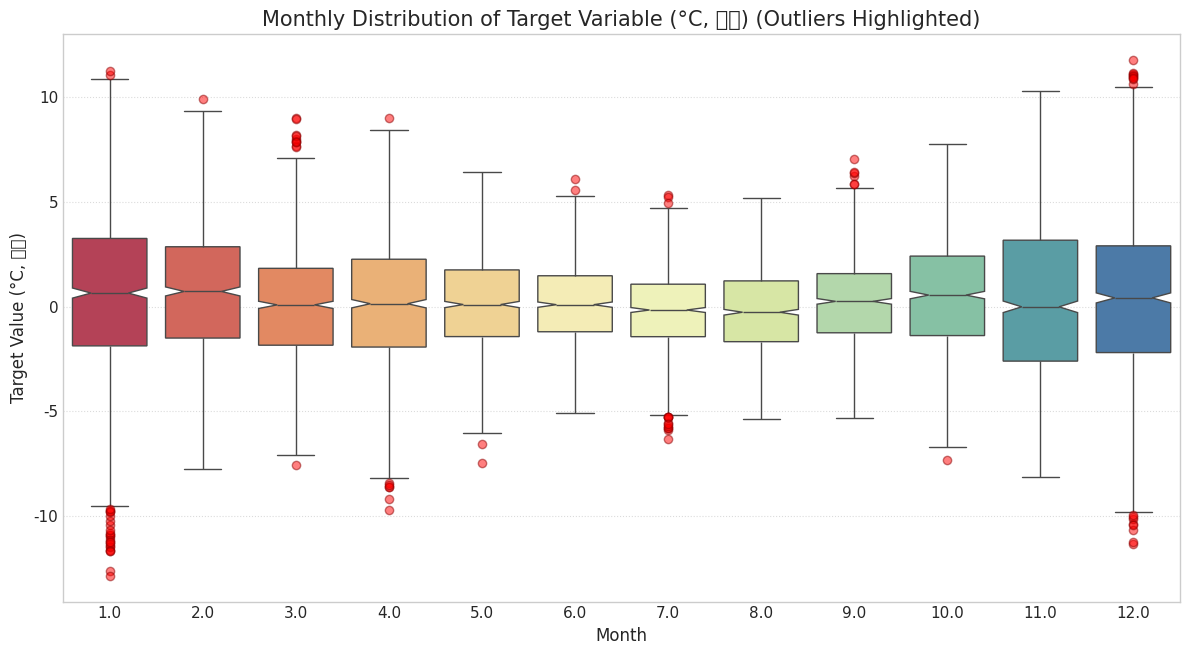

In [ ]:
if 'target' in train_df_analysis.columns and 'month' in train_df_analysis.columns:
    try:
        plt.figure(figsize=(15, 0.7)) 
        plt.figtext(0.5, 0.5, '4. Monthly Target Variation Analysis (Post-Imputation)',
                    ha='center', va='center', fontsize=18, weight='bold')
        plt.show()

        plt.figure(figsize=(12, 7))
        
        try:
            target_unit_month = get_unit('target')
        except NameError:
            print("Warning: get_unit() function is not defined. Unit will be omitted for Target.")
            target_unit_month = "" 

        monthly_target_data = train_df_analysis[['month', 'target']].dropna()

        if not monthly_target_data.empty and monthly_target_data['month'].nunique() > 0 :
            consistent_flierprops_target = {
                'marker': 'o',
                'markersize': 6,
                'markerfacecolor': 'red',
                'markeredgecolor': 'darkred',
                'alpha': 0.5  
            }

            sns.boxplot(x='month', y='target', data=monthly_target_data, palette="Spectral", notch=True,
                        flierprops=consistent_flierprops_target)  
            plt.title(f'Monthly Distribution of Target Variable {target_unit_month} (Outliers Highlighted)', fontsize=15)
            plt.xlabel('Month', fontsize=12)
            plt.ylabel(f'Target Value {target_unit_month}', fontsize=12)
            
            
            month_order = sorted(monthly_target_data['month'].unique().astype(int))
            
            plt.xticks(fontsize=11) 
            plt.yticks(fontsize=11)
            plt.grid(True, axis='y', linestyle=':', alpha=0.7)
            plt.tight_layout(rect=[0,0,1,0.95]) 
            plt.show()
        else:
            print("Warning: Insufficient data for 'target' or 'month' (or empty after NaN removal) to perform monthly Target analysis.")
    except NameError as e:
        print(f"Plotting library not imported or DataFrame not found. Please check imports and data. Error: {e}")
    except Exception as e:
        print(f"An error occurred during plotting: {e}")
else:
    print("Warning: 'target' or 'month' column not found. Skipping monthly Target analysis.")




<Figure size 1500x70 with 0 Axes>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon


--------------- Hourly Analysis for Surface Temp (°C) ---------------


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


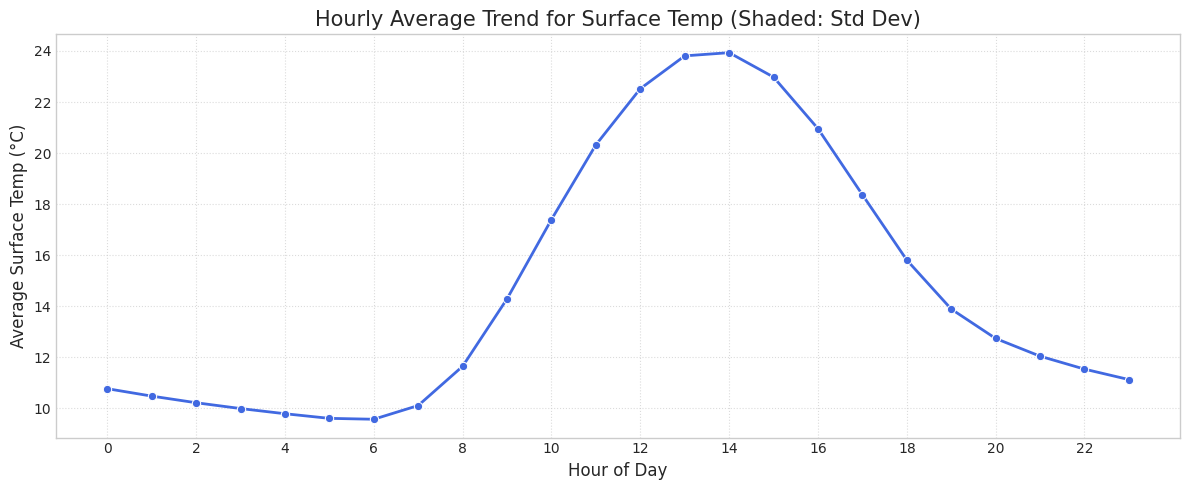

/tmp/ipykernel_5058/3461336830.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'N

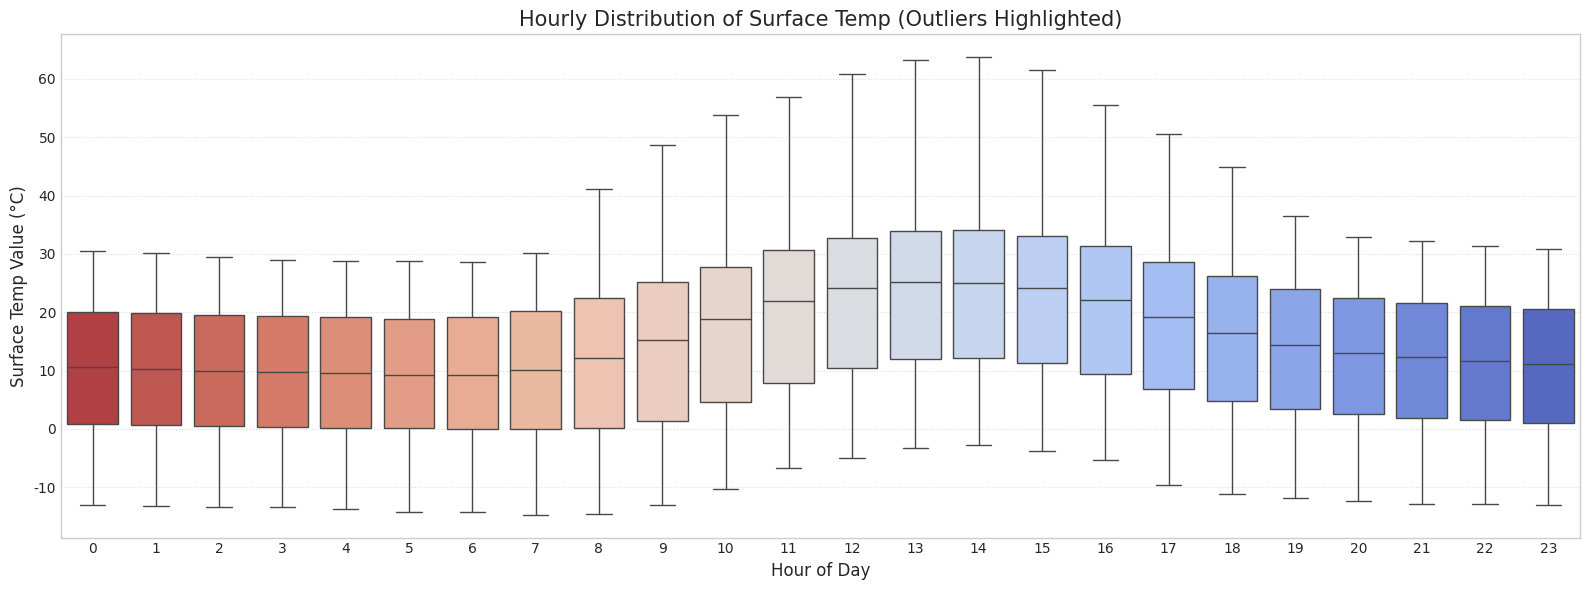

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon


--------------- Hourly Analysis for Dew Point (°C) ---------------


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


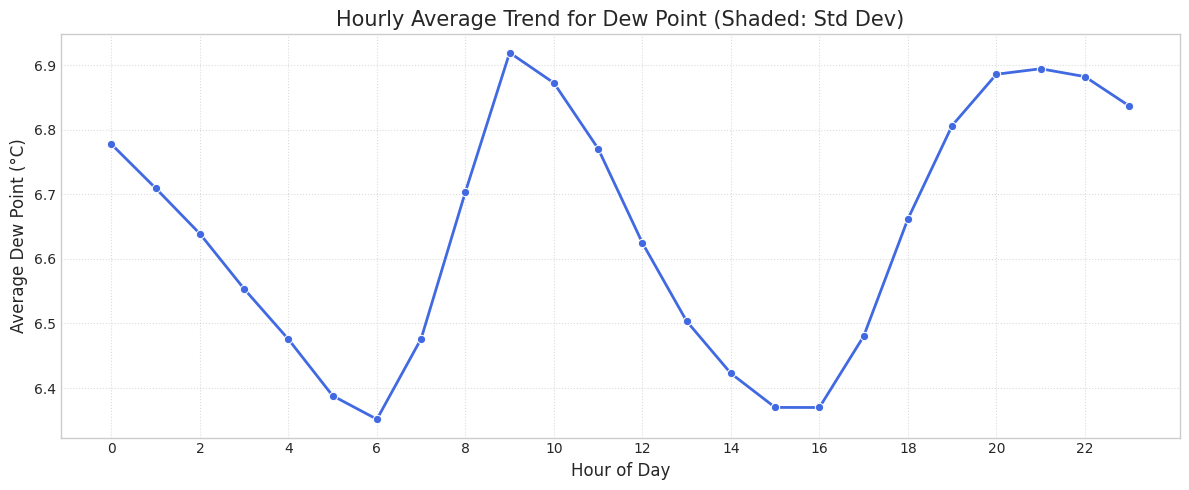

/tmp/ipykernel_5058/3461336830.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'N

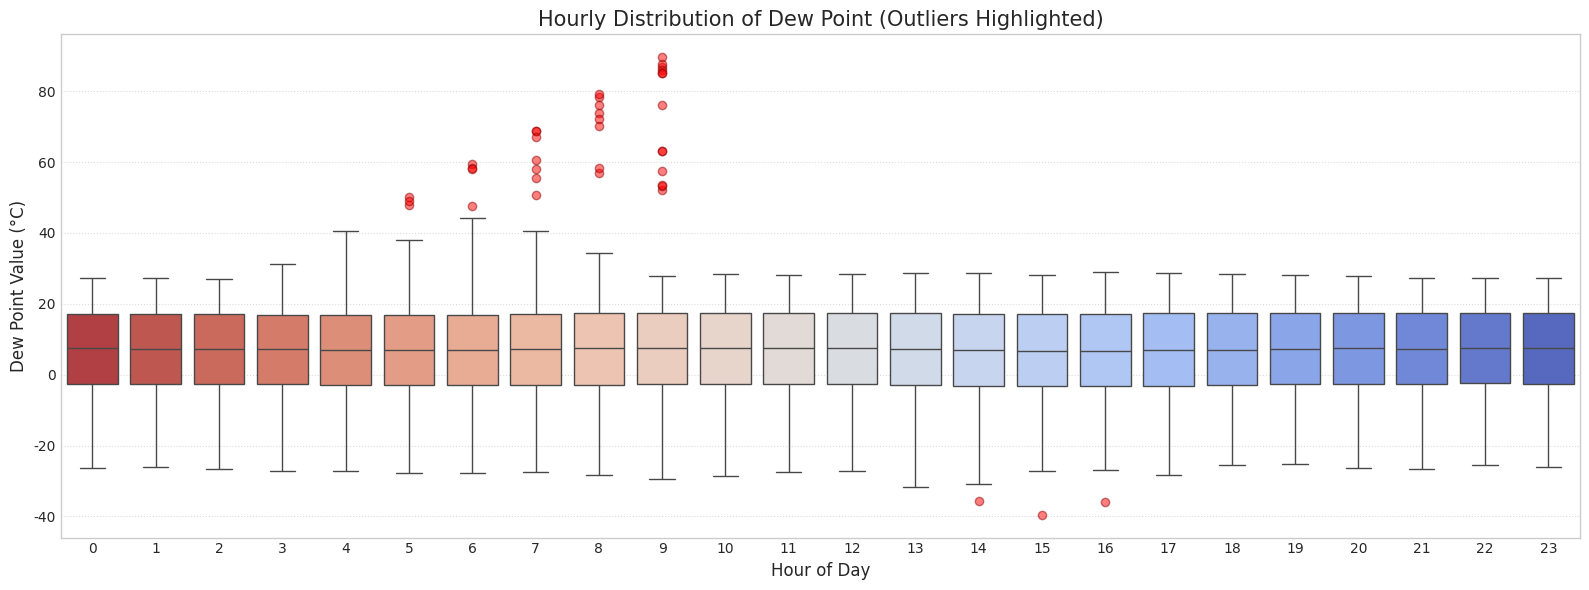

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon


--------------- Hourly Analysis for Humidity (%) ---------------


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


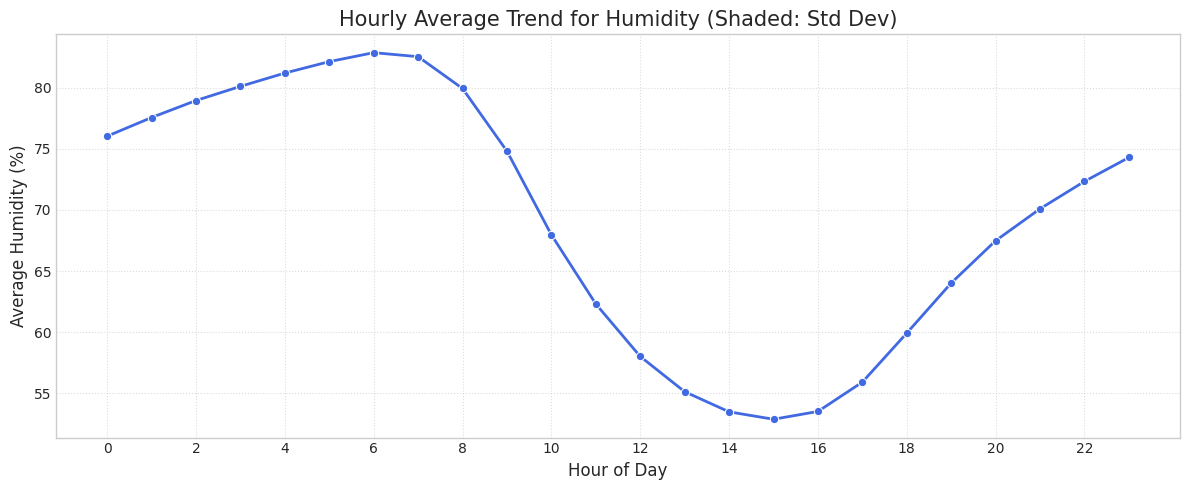

/tmp/ipykernel_5058/3461336830.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'N

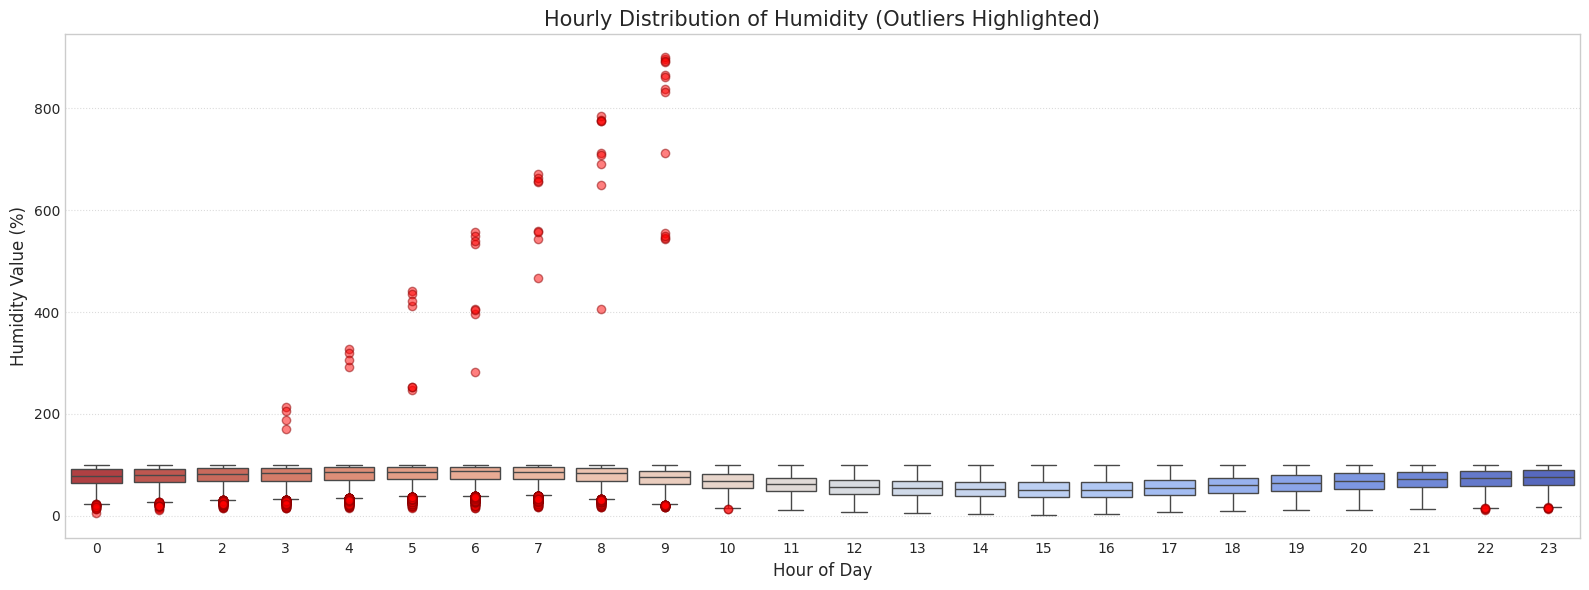

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon


--------------- Hourly Analysis for Wind Speed (m/s) ---------------


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


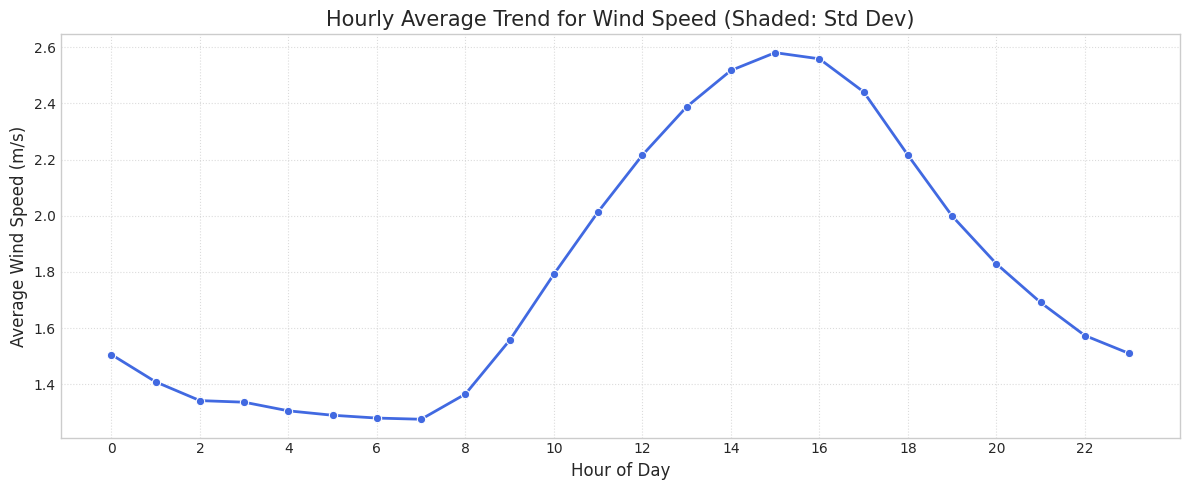

/tmp/ipykernel_5058/3461336830.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'N

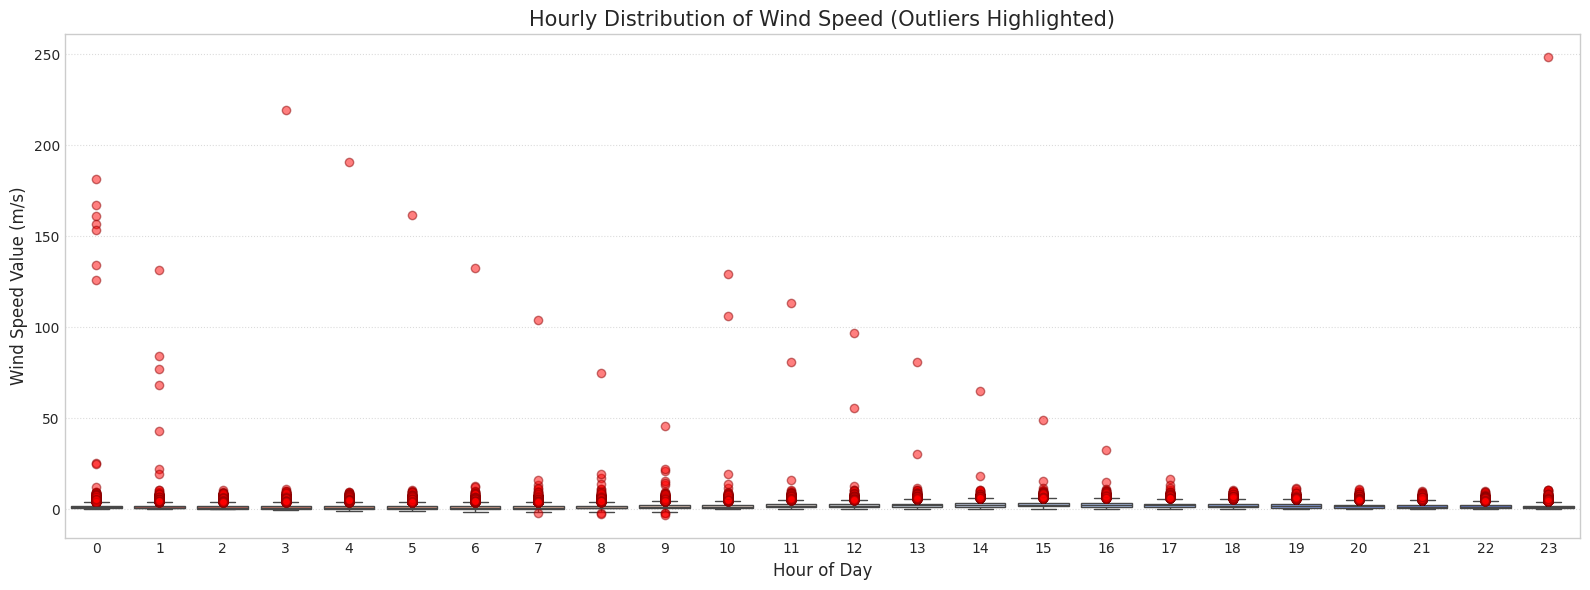

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykerne


--------------- Hourly Analysis for Cloud Cover (10분위) ---------------


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


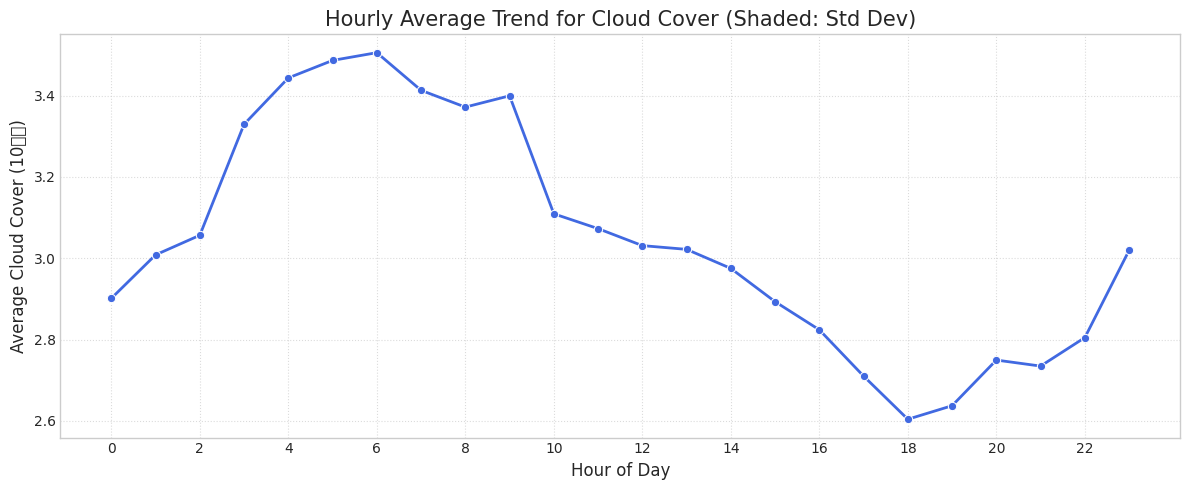

/tmp/ipykernel_5058/3461336830.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'N

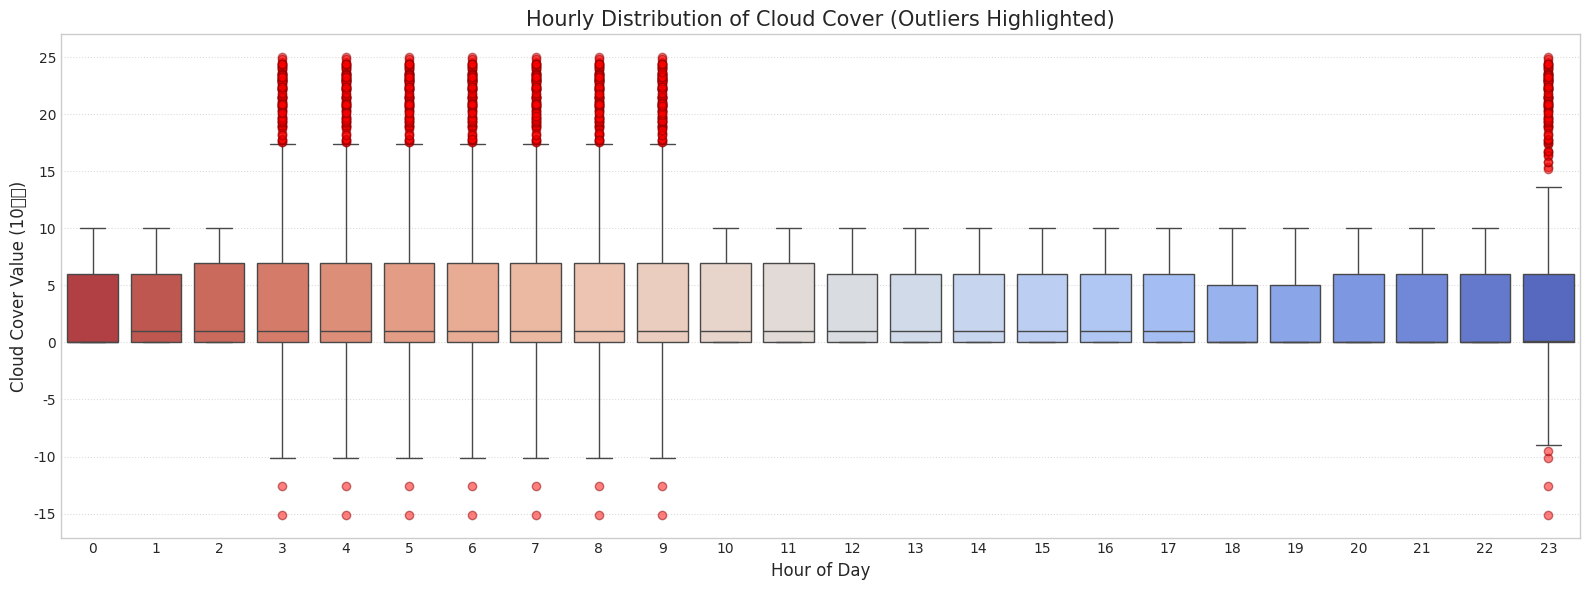

In [ ]:
HOURLY_FEATURES_TO_ANALYZE = {
    'surface_temp': 'surface_temp', 'dew_point': 'dew_point', 'humidity': 'humidity',
    'wind_speed': 'wind_speed', 'cloud_cover': 'cloud_cover'
}

try:
    plt.figure(figsize=(15, 0.7)) 
    plt.figtext(0.5, 0.5, '3. Analysis of Key Hourly Meteorological Variables (Post-Imputation)',
                ha='center', va='center', fontsize=18, weight='bold') 
    plt.show()
except NameError as e:
    print(f"Plotting library not imported. Please import matplotlib.pyplot as plt. Error: {e}")
    
if isinstance(HOURLY_FEATURES_TO_ANALYZE, dict):
    for base_feature_key, base_feature_name_for_unit in HOURLY_FEATURES_TO_ANALYZE.items():
        try:
            unit = get_unit(base_feature_name_for_unit)
        except NameError:
            print(f"Warning: get_unit() function is not defined. Units will be omitted for {base_feature_key}.")
            unit = "" 
            
        hourly_cols = [f"{base_feature_key}_{h}" for h in range(24)]
        
        try:
            existing_hourly_cols = [col for col in hourly_cols if col in train_df_analysis.columns]
        except NameError:
            print(f"Error: train_df_analysis DataFrame is not defined. Skipping analysis for {base_feature_key}.")
            continue 

        if not existing_hourly_cols:
            print(f"\nHourly columns for '{base_feature_key}' not found in train_df_analysis. Skipping.")
            continue

        feature_title_name = base_feature_key.replace('_', ' ').title()
        print(f"\n{'-'*15} Hourly Analysis for {feature_title_name} {unit} {'-'*15}")

        hourly_means = train_df_analysis[existing_hourly_cols].mean(axis=0, skipna=True)
        if hourly_means.isnull().all():
            print(f"All hourly means for '{feature_title_name}' are NaN. Skipping line plot.")
        else:
            hourly_means.index = [int(col.split('_')[-1]) for col in hourly_means.index] # Ensure correct parsing of hour
            hourly_means = hourly_means.sort_index()
            try:
                plt.figure(figsize=(12, 5))
                sns.lineplot(x=hourly_means.index, y=hourly_means.values, marker='o', errorbar='sd', color='royalblue', lw=2)
                plt.title(f'Hourly Average Trend for {feature_title_name} (Shaded: Std Dev)', fontsize=15)
                plt.xlabel('Hour of Day', fontsize=12)
                plt.ylabel(f'Average {feature_title_name} {unit}', fontsize=12)
                plt.xticks(range(0, 24, 2), fontsize=10); plt.yticks(fontsize=10)
                plt.grid(True, linestyle=':', alpha=0.7); plt.tight_layout(); plt.show()
            except Exception as e:
                print(f"Error plotting line plot for {feature_title_name}: {e}")

        melted_df = train_df_analysis[existing_hourly_cols].copy()
        if melted_df.isnull().all().all(): 
            print(f"All hourly data for '{feature_title_name}' are NaN. Skipping box plot.")
        else:
            melted_df.columns = [int(col.split('_')[-1]) for col in melted_df.columns] 
            melted_df = melted_df.melt(var_name='hour', value_name=base_feature_key)
            melted_df_no_nan_boxplot = melted_df.dropna(subset=[base_feature_key])

            if not melted_df_no_nan_boxplot.empty:
                try:
                    plt.figure(figsize=(16, 6))
                    
                    consistent_flierprops = {
                        'marker': 'o',  
                        'markersize': 6, 
                        'markerfacecolor': 'red',
                        'markeredgecolor': 'darkred', 
                        'alpha': 0.5  
                    }
                    plot_title = f'Hourly Distribution of {feature_title_name} (Outliers Highlighted)'
                
                    sns.boxplot(x='hour', y=base_feature_key, data=melted_df_no_nan_boxplot, palette="coolwarm_r",
                                flierprops=consistent_flierprops) 
                    
                    plt.title(plot_title, fontsize=15)
                    plt.xlabel('Hour of Day', fontsize=12)
                    plt.ylabel(f'{feature_title_name} Value {unit}', fontsize=12)
                    plt.xticks(range(0, 24, 1), fontsize=10); plt.yticks(fontsize=10)
                    plt.grid(True, axis='y', linestyle=':', alpha=0.7); plt.tight_layout(); plt.show()
                except Exception as e:
                    print(f"Error plotting box plot for {feature_title_name}: {e}")

            else:
                print(f"Data for '{feature_title_name}' is empty after removing NaN. Cannot draw box plot.")
else:
    print("Warning: 'HOURLY_FEATURES_TO_ANALYZE' dictionary is not defined. Skipping hourly analysis.")

<Figure size 1000x50 with 0 Axes>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

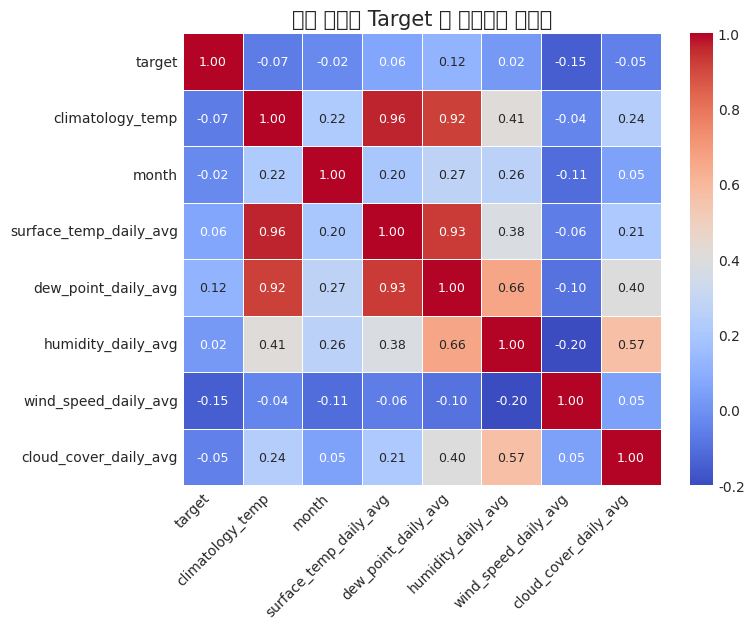


--- Target과의 상관계수 (절대값 높은 순) ---
target                    1.000000
wind_speed_daily_avg      0.150629
dew_point_daily_avg       0.116530
climatology_temp          0.067867
surface_temp_daily_avg    0.064782
cloud_cover_daily_avg     0.051942
month                     0.024693
humidity_daily_avg        0.023139
Name: target, dtype: float64


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_5058/982142751.py:79: UserWarning: Glyph 54200 (\N{HANGUL SYLLABLE PYEON}) missing from font(s) DejaVu Sans.
  fig_sc.tight_layout(rect=[0, 0.02, 1, 0.96]); plt.show()
/tmp/ipykernel_5058/982142751.py:79: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig_sc.tight_layout(rect=[0, 0.02, 1, 0.96]); plt.show()
findfont: Font family 'Nan

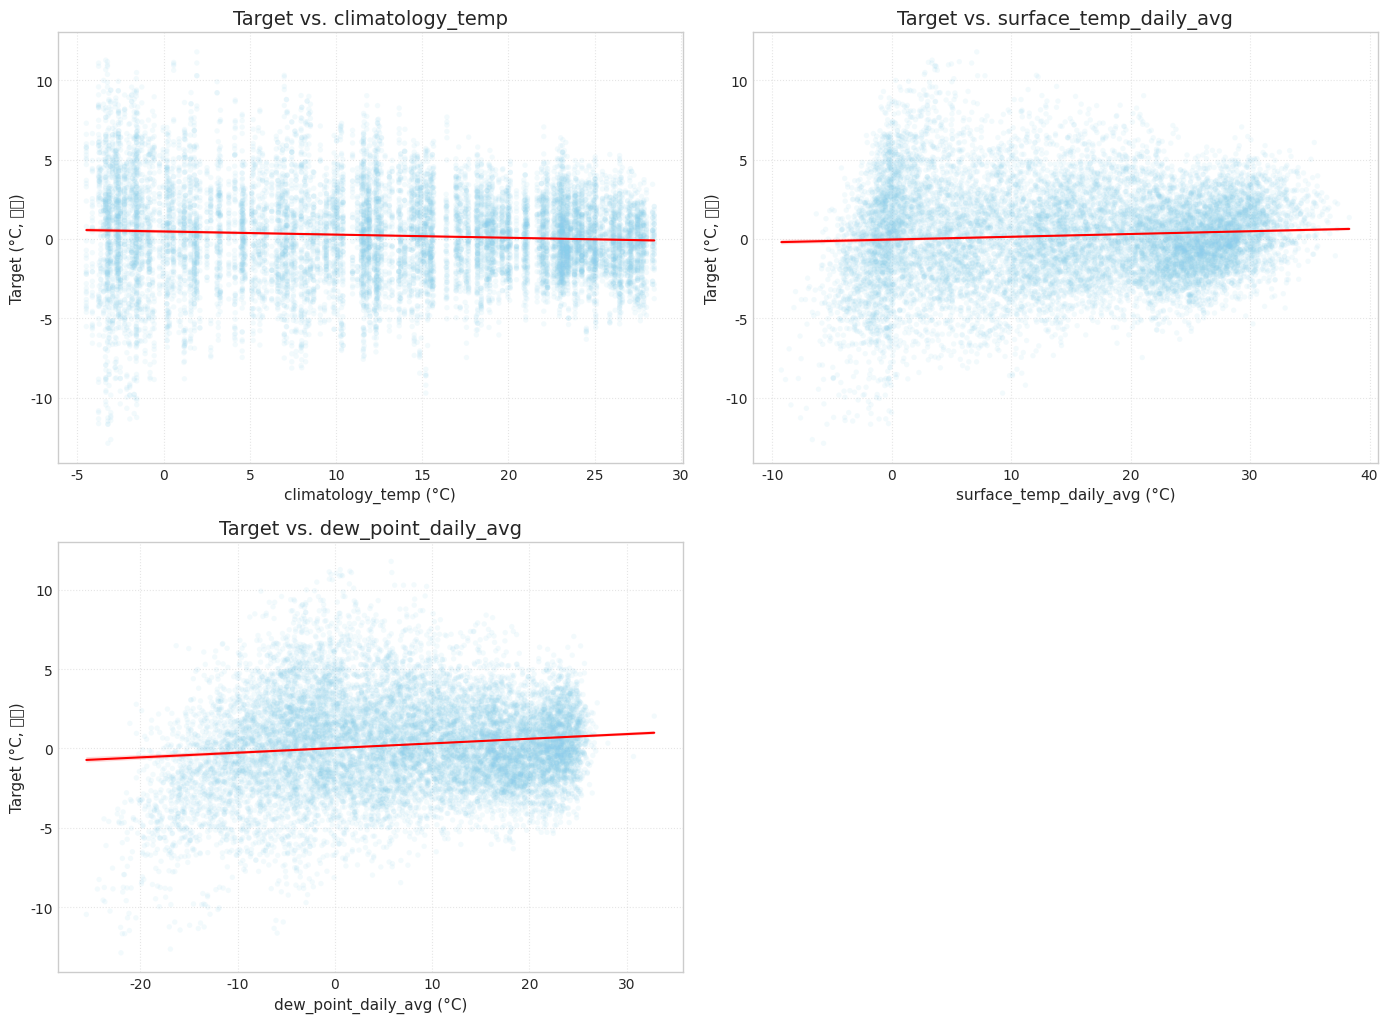

In [ ]:
if 'target' in train_df_analysis.columns and not train_df_analysis['target'].isnull().all():
    fig_title_corr = plt.figure(figsize=(10, 0.5))
    plt.figtext(0.5, 0.5, '5. 주요 변수와 Target 간 관계 분석 (전처리 후)',
                ha='center', va='center', fontsize=18, weight='bold', figure=fig_title_corr)
    plt.show(fig_title_corr)
    corr_df_analysis_base = train_df_analysis.dropna(subset=['target']).copy()
    target_unit_corr = get_unit('target')

    cols_for_corr_heatmap = ['target']
    if 'climatology_temp' in corr_df_analysis_base.columns:
        cols_for_corr_heatmap.append('climatology_temp')
    if 'month' in corr_df_analysis_base.columns:
        cols_for_corr_heatmap.append('month')

    if 'HOURLY_FEATURES_TO_ANALYZE' in locals() and isinstance(HOURLY_FEATURES_TO_ANALYZE, dict):
        for base_feature_key, base_feature_name in HOURLY_FEATURES_TO_ANALYZE.items():
            daily_avg_col_name = f'{base_feature_key}_daily_avg' 
            hourly_cols_for_avg = [f"{base_feature_key}_{h}" for h in range(24) if f"{base_feature_key}_{h}" in corr_df_analysis_base.columns]
            if hourly_cols_for_avg:

                corr_df_analysis_base[daily_avg_col_name] = corr_df_analysis_base[hourly_cols_for_avg].mean(axis=1, skipna=True)
                if daily_avg_col_name not in cols_for_corr_heatmap and not corr_df_analysis_base[daily_avg_col_name].isnull().all(): # 모두 NaN인 컬럼은 제외
                     cols_for_corr_heatmap.append(daily_avg_col_name)
    
    final_cols_for_heatmap = [col for col in cols_for_corr_heatmap if col in corr_df_analysis_base.columns and pd.api.types.is_numeric_dtype(corr_df_analysis_base[col]) and not corr_df_analysis_base[col].isnull().all()]

    if len(final_cols_for_heatmap) > 1:
        correlation_matrix = corr_df_analysis_base[final_cols_for_heatmap].dropna().corr()
        
        if not correlation_matrix.empty and 'target' in correlation_matrix.columns:
            plt.figure(figsize=(max(8, len(final_cols_for_heatmap)*0.9), max(6, len(final_cols_for_heatmap)*0.8)))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,
                        annot_kws={"size":9 if len(final_cols_for_heatmap) < 10 else 7})
            plt.title('주요 변수와 Target 간 상관관계 히트맵', fontsize=15)
            plt.xticks(rotation=45, ha='right', fontsize=10 if len(final_cols_for_heatmap) < 10 else 8)
            plt.yticks(rotation=0, fontsize=10 if len(final_cols_for_heatmap) < 10 else 8)
            plt.tight_layout(); plt.show()

            print(f"\n--- Target과의 상관계수 (절대값 높은 순) ---")
            print(correlation_matrix['target'].abs().sort_values(ascending=False))

            scatter_plot_vars_dict = {}
            if 'climatology_temp' in final_cols_for_heatmap:
                 scatter_plot_vars_dict['climatology_temp'] = 'climatology_temp'
            if 'surface_temp_daily_avg' in final_cols_for_heatmap: 
                 scatter_plot_vars_dict['surface_temp_daily_avg'] = 'surface_temp'
            if 'dew_point_daily_avg' in final_cols_for_heatmap: 
                 scatter_plot_vars_dict['dew_point_daily_avg'] = 'dew_point'

            if scatter_plot_vars_dict:
                num_scatter = len(scatter_plot_vars_dict)
                if num_scatter > 0:
                    n_cols_sc = min(num_scatter, 2); n_rows_sc = math.ceil(num_scatter / n_cols_sc)
                    fig_sc, axes_sc = plt.subplots(n_rows_sc, n_cols_sc, figsize=(n_cols_sc * 7, n_rows_sc * 5.5), squeeze=False)
                    axes_sc = axes_sc.flatten(); plot_idx_sc = 0
                    for col_to_plot, base_name_for_unit in scatter_plot_vars_dict.items():
                        plot_data_scatter = corr_df_analysis_base[['target', col_to_plot]].dropna()
                        if not plot_data_scatter.empty and col_to_plot != 'target':
                            unit_sc = get_unit(base_name_for_unit); ax_current = axes_sc[plot_idx_sc]
                            sns.regplot(x=plot_data_scatter[col_to_plot], y=plot_data_scatter['target'], ax=ax_current,
                                        scatter_kws={'alpha':0.1, 's':15, 'color':'skyblue', 'edgecolor':'none'},
                                        line_kws={'color':'red', 'lw':1.5})
                            ax_current.set_title(f'Target vs. {col_to_plot}', fontsize=14)
                            ax_current.set_xlabel(f'{col_to_plot} {unit_sc}', fontsize=11)
                            ax_current.set_ylabel(f'Target {target_unit_corr}', fontsize=11)
                            ax_current.tick_params(axis='both', which='major', labelsize=10)
                            ax_current.grid(True, linestyle=':', alpha=0.5); plot_idx_sc += 1
                    for i in range(plot_idx_sc, len(axes_sc)): fig_sc.delaxes(axes_sc[i])
                    fig_sc.tight_layout(rect=[0, 0.02, 1, 0.96]); plt.show()
                else: print("산점도를 그릴 유효한 변수가 없습니다 (scatter_plot_vars_dict 비어있음).")
            else: print("산점도 대상 변수 목록이 비어있습니다.")
        else: print("상관계수 계산 후 유효한 데이터가 없거나 'target' 컬럼이 없습니다.")
    else: print("상관관계 히트맵 및 산점도 분석을 위한 충분한 (2개 이상) 수치형 변수가 없습니다.")
else:
    print("경고: 'target' 컬럼이 없거나 모든 값이 NaN이어서 주요 변수와의 관계 분석을 건너<0xEB><0A><0x88>니다.")




In [ ]:
print("\n--- 상세 EDA (결측치 처리 후 데이터 사용) 완료 ---")
print(f"분석에 사용된 데이터프레임 (train_df_analysis) shape: {train_df_analysis.shape}")
print(f"최종 결측치 개수 (train_df_analysis): {train_df_analysis.isnull().sum().sum()}")
print("\n다음 단계: Feature Engineering 및 모델링")


--- 상세 EDA (결측치 처리 후 데이터 사용) 완료 ---
분석에 사용된 데이터프레임 (train_df_analysis) shape: (13132, 343)
최종 결측치 개수 (train_df_analysis): 12

다음 단계: Feature Engineering 및 모델링
